# Project: Titanic生存预测竞赛

## Introdution

### 项目介绍
本次项目是在Kaggle上的一个竞赛项目，项目名称为：[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)。本次实验使用对Titanic上的乘客数据集进行了数据挖掘，并且使用多种预测模型对乘客的生存状态进行了预测。最终也取得了很好的效果，获得了Kaggle竞赛排名的Top3%。

在此实验中，我采用多种模型，多种参数和多种随机状态选择，在随机森林的最优调参上取得了最佳的结果，为方便起见我将预测文件一并提交并且描述了我的所有尝试过程。因为随机种子和交叉验证的分类集每次都会有比较大的差别，所以分数也会随着每次提交不断改变，在这里我附上了最佳结果的分数和预测文件my_best_submission.csv。
![结果图](./res.png)

### 项目流程
本次实验采用了数据挖掘的经典流程进行处理：数据集分析与可视化，数据清洗与特征提取和训练模型
* 数据分析与可视化：主要使用python可视化库对数据集重要部分做了分析
* 数据清洗：使用Pandas读取数据，并对数据进行清洗，包括数据清洗、缺失值填充、特征工程、数据分割等。
* 训练模型：尝试了大量模型，包括随机森林、决策树、支持向量机、KNN、SVM、逻辑回归、梯度提升树、神经网络等。

### 主要方法与尝试
本项目主要使用的方法与模型有：
* 决策模型使用：
  * GBDT：Gradient Boosting Decision Tree，梯度提升决策树。
  * XGBoost：深度学习决策框架。
  * Random Forest：随机森林。
  * SVMC：Support Vector Machine Classifier，支持向量机分类器。
* 组合预测模型的使用：使用投票树将上述决策模型进行ensemble。

### 数据集介绍
本此比赛的数据集为Titanic上的乘客信息，具体的属性介绍如下：
* PassengerId：乘客的编号。
* Pclass：乘客的船舱等级，1为经济舱，2为豪华舱，3为商务舱。
* Survived：乘客是否存活，0为死亡，1为生存。
* Name：乘客的姓名。
* Sex：乘客的性别
* Age：乘客的年龄
* SibSp：乘客的兄弟姐妹与配偶数量
* Parch：乘客的父母与子女数量
* Ticket：乘客的票的编号
* Fare：票价
* Cabin：乘客的座位号
* Embarked：乘客的登船港口

### 文件介绍
* titanic.ipynb 各种尝试的集合体，最优分数0.80622
* titanic2.ipynb 随机森林模型的最优解，最优分数0.80143

## 数据集分析与可视化

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### 加载数据集
加载训练数据集，并且通过descibe()方法和isnull()方法对数据集进行简单的初步分析

In [46]:
test_data = pd.read_csv("kaggle/input/titanic/test.csv")
train_data = pd.read_csv("kaggle/input/titanic/train.csv")

数据集加载后的大致结构如下：

In [47]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


通过isnull()函数可以看到有大量缺失值需要处理

In [97]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 缺失值分析
在这一部分我们可以简单的分析一下缺失值的分布和缺失值之间的关系，为后续数据清洗做准备。首先可以通过missingno库可视化的查看缺失的数据情况，可以看到乘客的年龄和Cabin信息缺失比较严重

<AxesSubplot:>

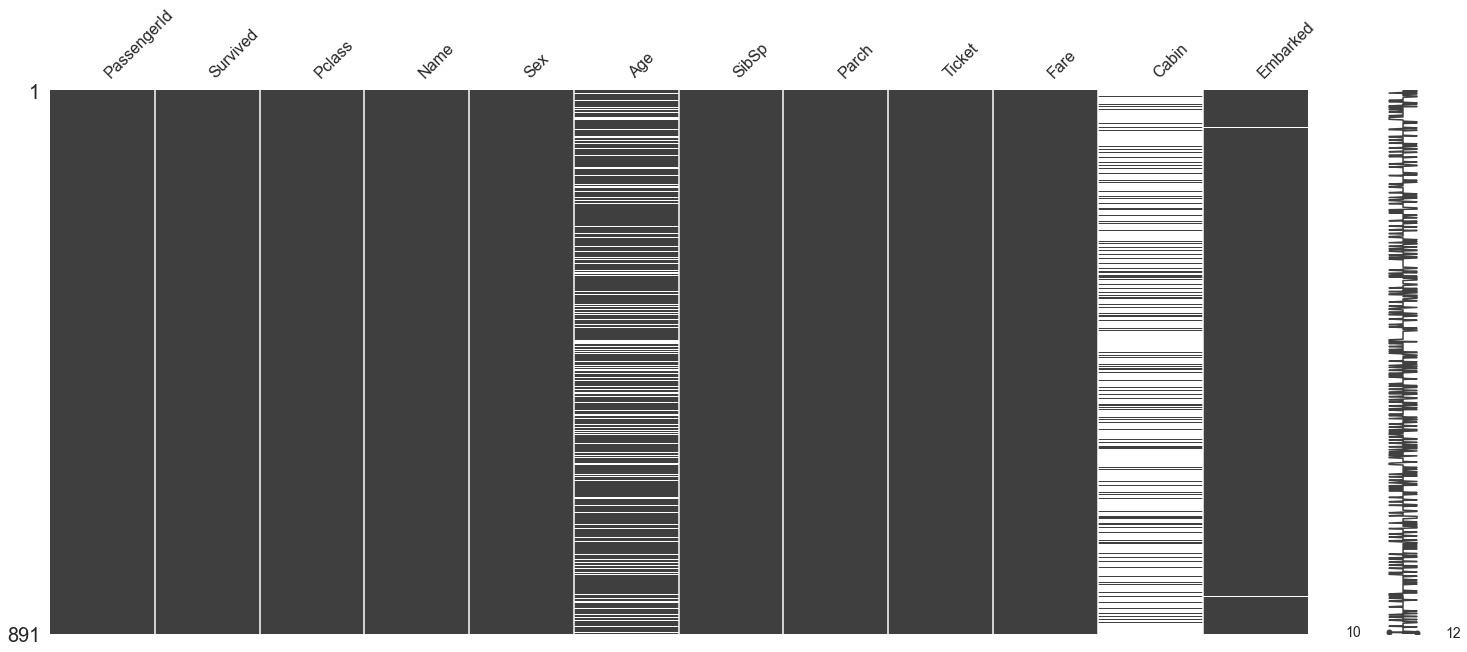

In [49]:
import missingno as msno
msno.matrix(train_data)

为了更好的对缺失的数据进行处理，我们先通过missingno库方法查看缺失数据的heatmap，以期找到缺失数据与其它数据的相关性，我们通过结果得知它们之间的联系不大，可以单独进行处理

<AxesSubplot:>

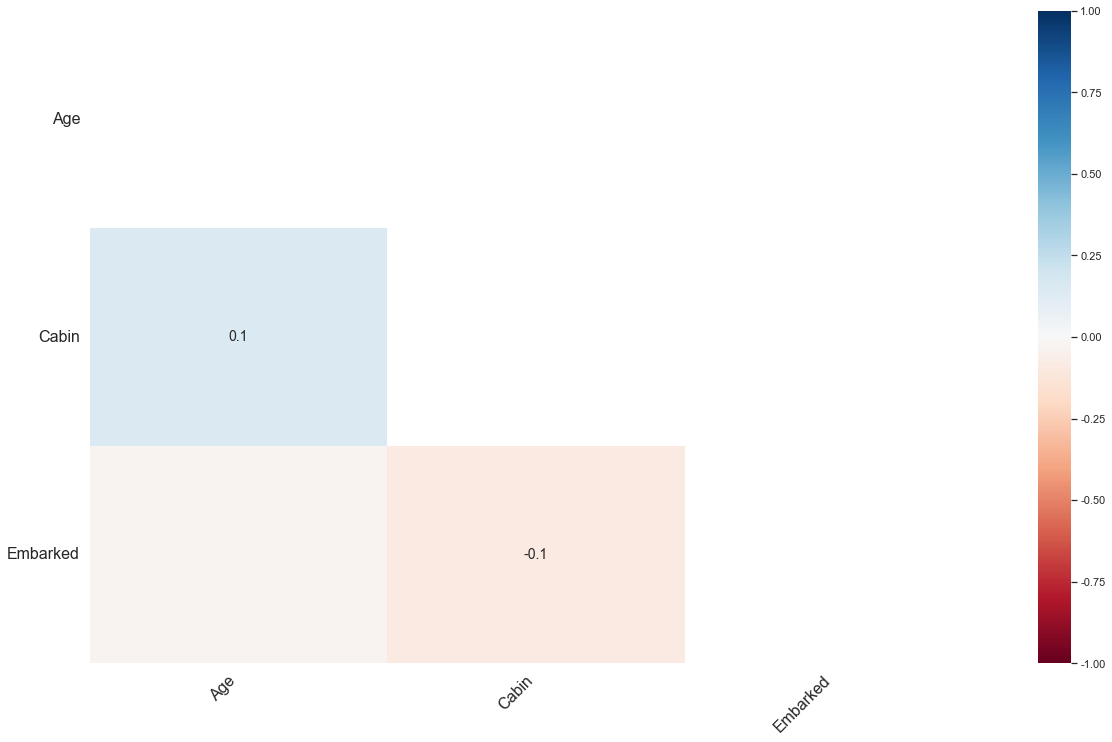

In [50]:
msno.heatmap(train_data)

为了填补缺失数较少的Embarked(登船港口)信息，我们可以先通过饼状图了解Embarked的分布，并且在以后选择分布最多的编号来进行填补。

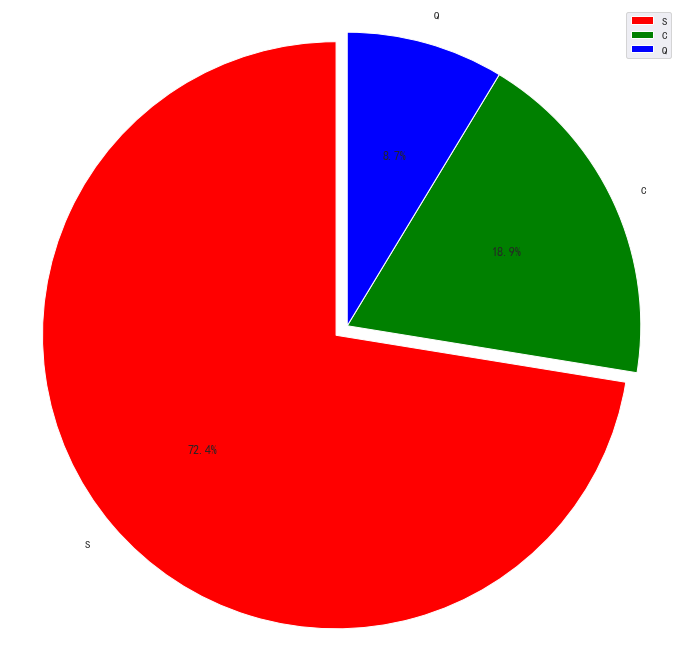

In [51]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

label_list = ["S", "C", "Q"]
size = [train_data['Embarked'].value_counts()[0], train_data['Embarked'].value_counts()[1], train_data['Embarked'].value_counts()[2]]
color = ["red", "green", "blue"]     
explode = [0.05, 0, 0]

patches, l_text, p_text = plt.pie(size, explode=explode, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")
plt.legend()
plt.show()



从上图得知，大部分乘客的Embarked都是S，所以我们合理猜测缺失数据为'S'的可能性最大

虽然Embarked属性的填充比较简单，但对于乘客年龄的填充是本次实验的非常棘手也是非常关键的一点，因为年龄数据可能需要使用随机森林依赖其他属性数据生成，所以我首先使用scatter matrix(矩阵散点图)来展示数据之间的相关性，并且给出heatmap。

array([[<AxesSubplot:xlabel='PassengerId', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Survived', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Pclass', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Age', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='SibSp', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Parch', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Fare', ylabel='PassengerId'>],
       [<AxesSubplot:xlabel='PassengerId', ylabel='Survived'>,
        <AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Survived'>,
        <AxesSubplot:xlabel='Parch', ylabel='Survived'>,
        <AxesSubplot:xlabel='Fare', ylabel='Survived'>],
       [<AxesSubplot:xlabel='PassengerId', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass', ylabel='

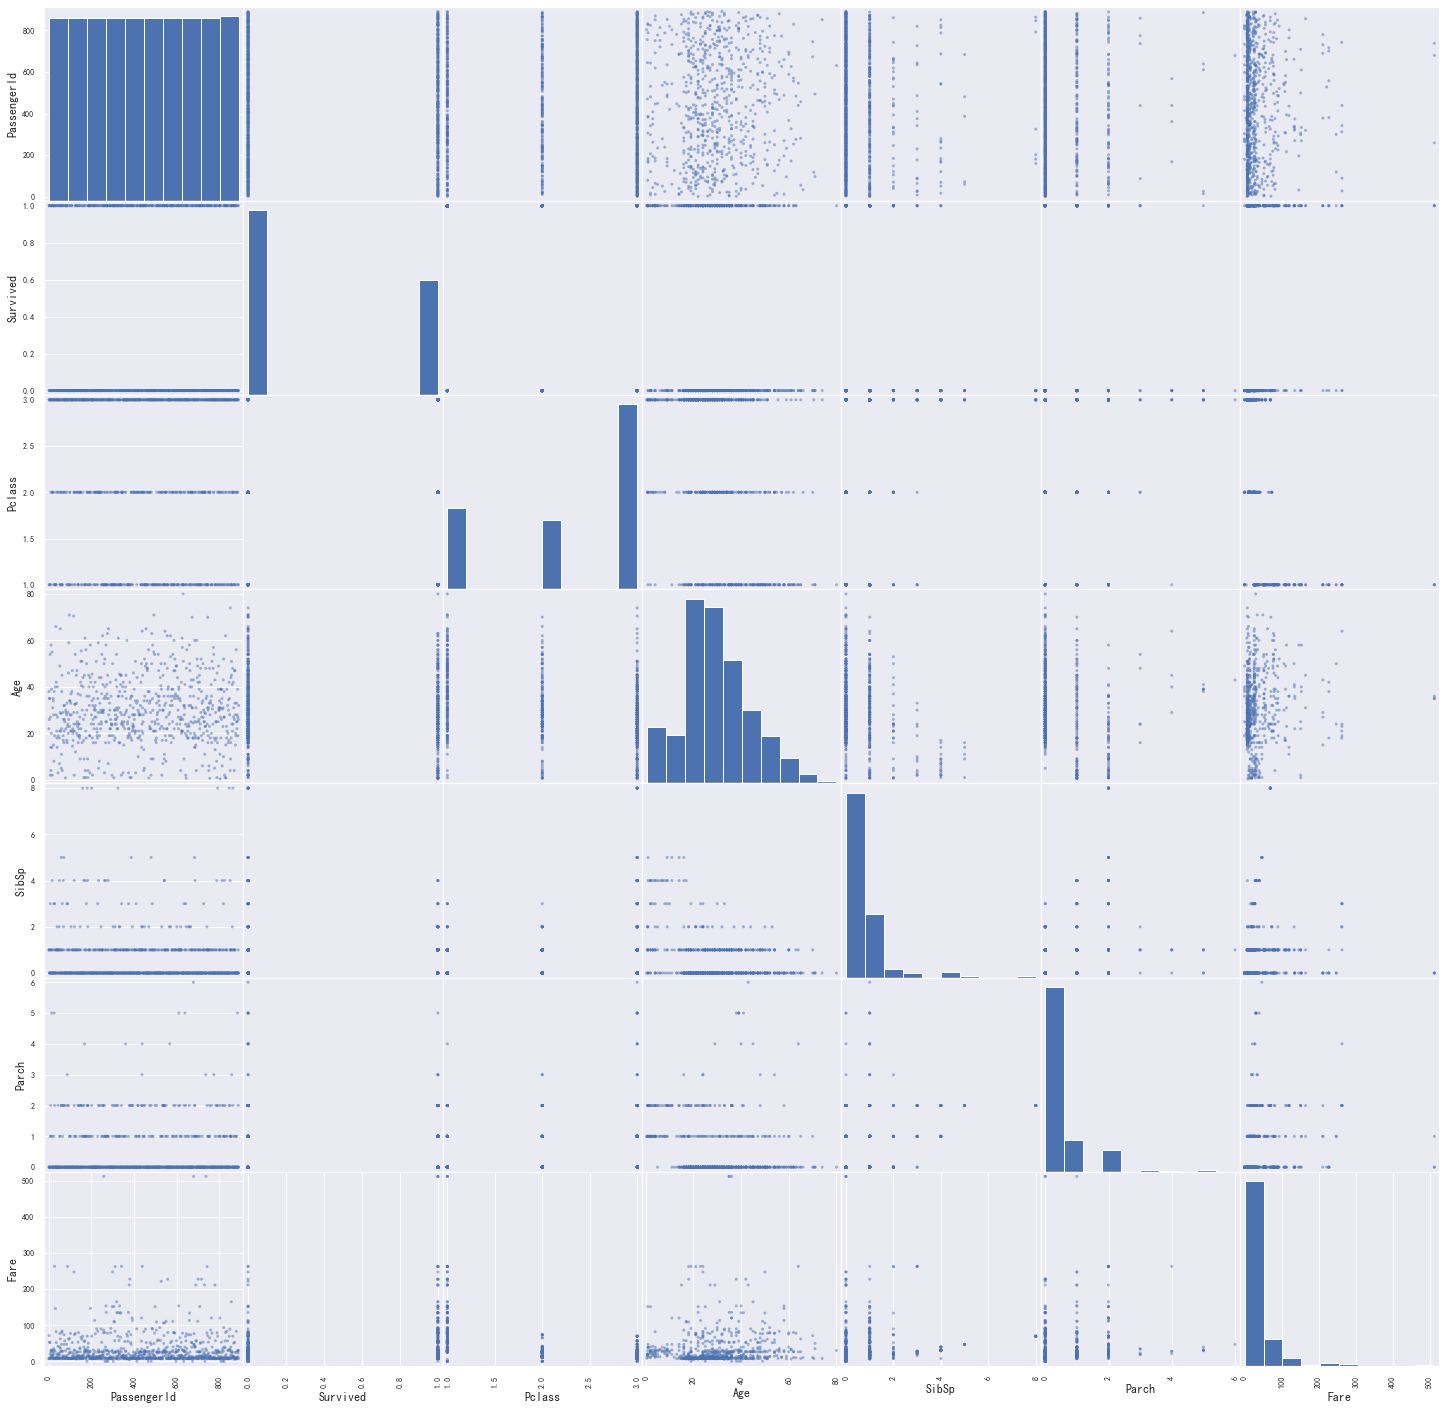

In [52]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_data, figsize = (25, 25))

(7.5, -0.5)

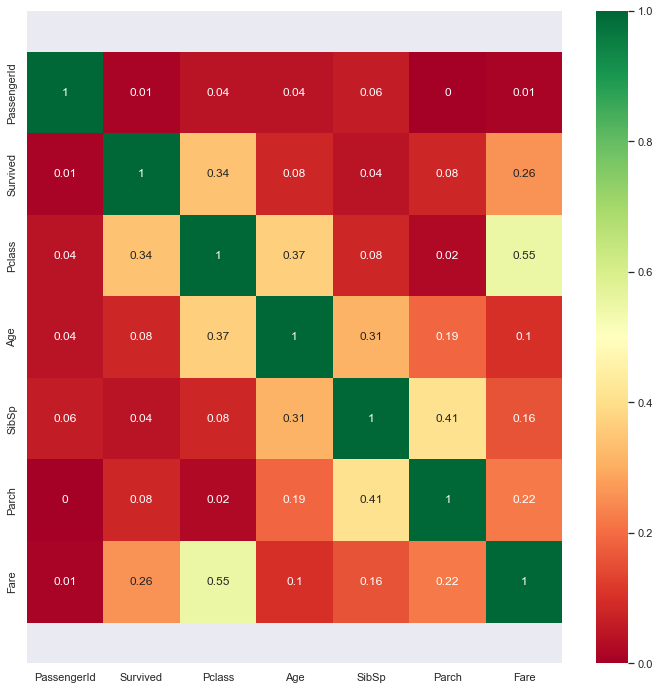

In [53]:
import seaborn as sns
correlation_matrix = np.absolute(train_data.corr().round(2))
sns.set(rc={'figure.figsize':(12, 12)})
ax = sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

从上面两张图我们可以直观地看到一些关系。比如生存率可能与PClass(舱位)，Fare(票价)联系比较紧密，后续操作可能会优先从这两个因素入手。同时从heatmap我们也可得知票价与舱位的相关性比较大，符合直觉。下面就要使用条形图和箱线图等对生存率与其他数据之间的联系进行进一步的分析。

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

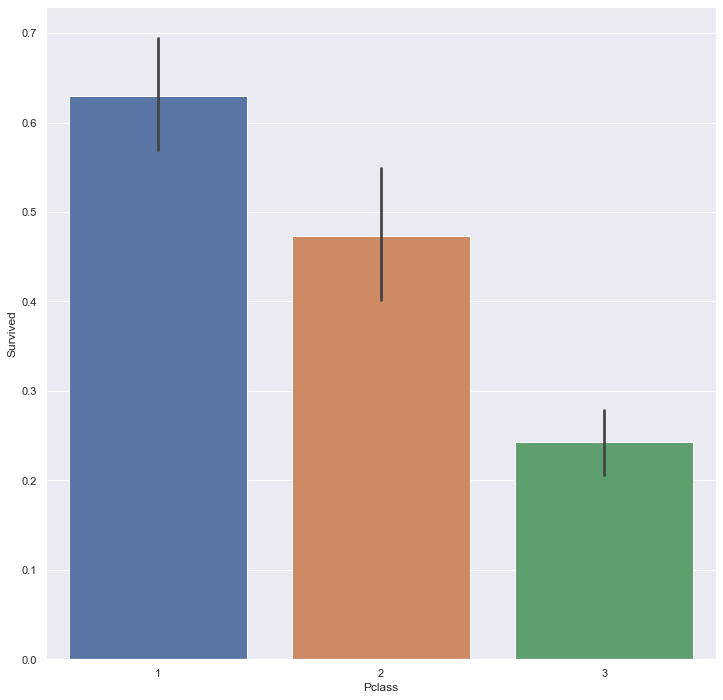

In [54]:
sns.barplot(x='Pclass',y='Survived',data=train_data)

从上条形可以看到生存率与舱位之间的关系，舱位1的生存率明显高于其他两个舱位，达到了62%左右的生存率。

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

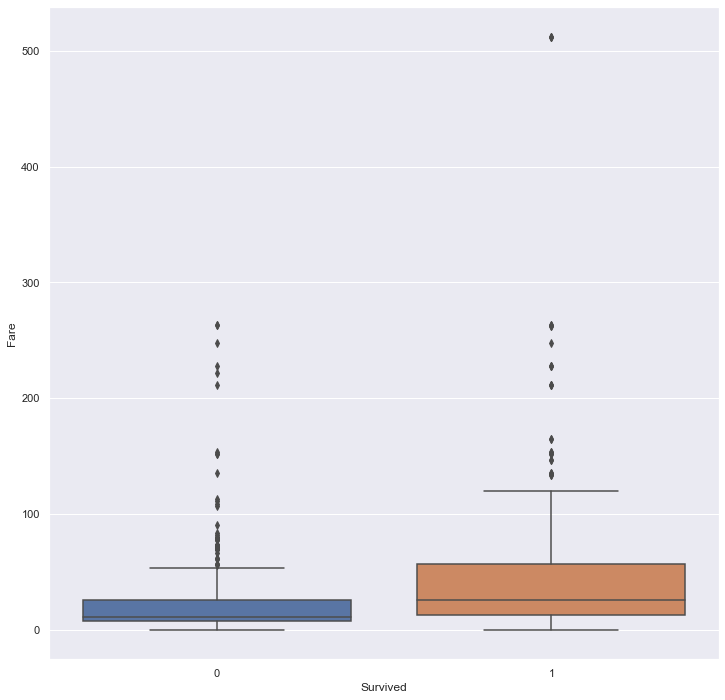

In [55]:
sns.boxplot(x='Survived',y='Fare',data=train_data)

前面我们提到过票价与舱位联系比较紧密，所以我们就可以推测生存率与票价也有一定的联系，在这里我们通过箱线图来可视化两者之间的关系。从上图可以看到，生存下来的乘客购买的票价明显高于死亡乘客。除了舱位与票价之外，我们不难通过经验推测出性别和年龄也与生存率有一定的关系。下面我们就借助几个常用的可视化工具来进行分析。

首先可以对乘客的年龄分布做一个简单分析，获取大概的认知。通过直方图可以得知年龄分布主要集中在20-40岁之间。并且我还使用Q-Q图去分析年龄分布是否符合正态分析，但从结果来看年龄的正态分布趋势不明显。

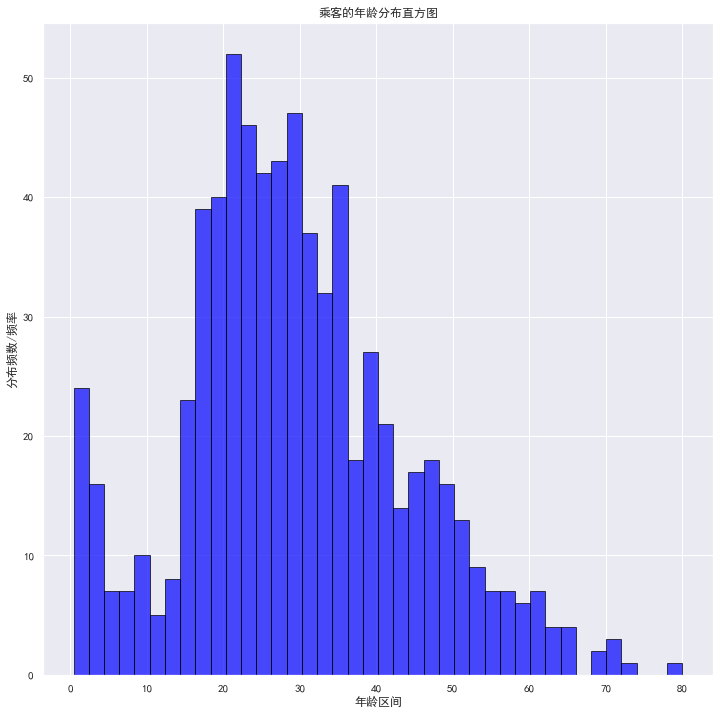

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['axes.unicode_minus'] = False     

plt.hist(train_data['Age'], bins = 40, facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.xlabel("年龄区间")
plt.ylabel("分布频数/频率")
plt.title("乘客的年龄分布直方图")
plt.show()

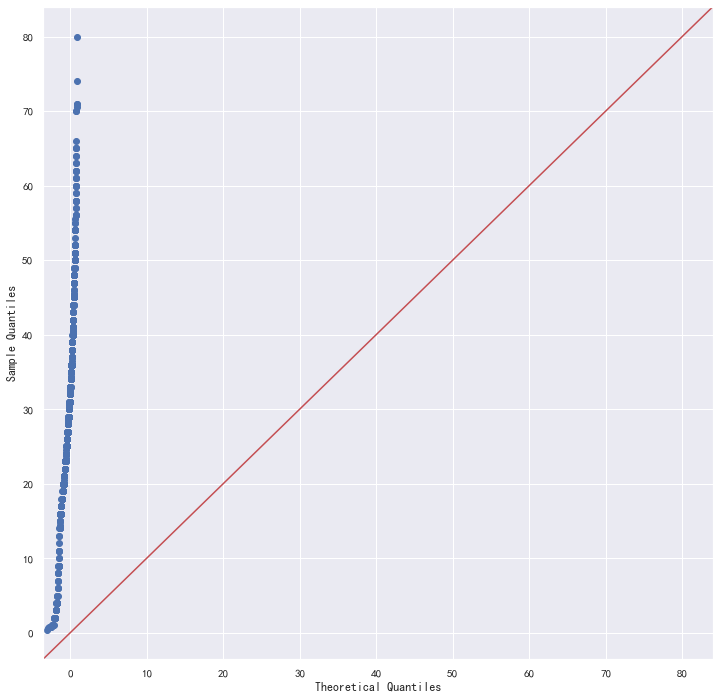

In [57]:
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py
  
sm.qqplot(train_data['Age'], line ='45')
py.show()

前面提到票价与生存率有紧密的联系，那么票价分布与年龄分布是否有某种联系呢？我们可以通过直方图来统计票价的分布，并且将其与年龄分步进行对比。可以看到票价大部分分布在低价区间。

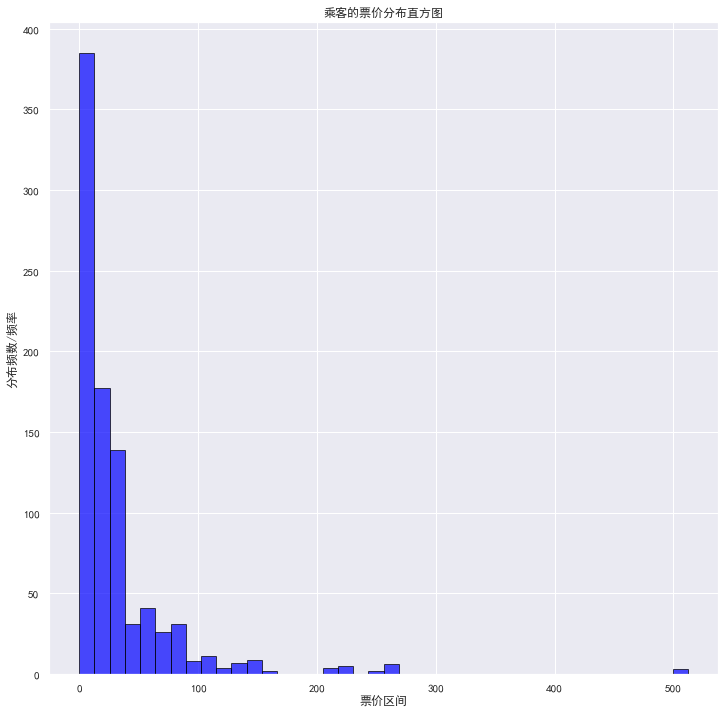

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['axes.unicode_minus'] = False     

plt.hist(train_data['Fare'], bins = 40, facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.xlabel("票价区间")
plt.ylabel("分布频数/频率")
plt.title("乘客的票价分布直方图")
plt.show()

知道了年龄分布之后，我们就可以分析年龄与生存率之间的关系，这里使用FacetGrid来对数据进行统计，可以清楚地看出年龄与生存率的分布，从图中可以明显看出0-10岁的乘客生存率最高

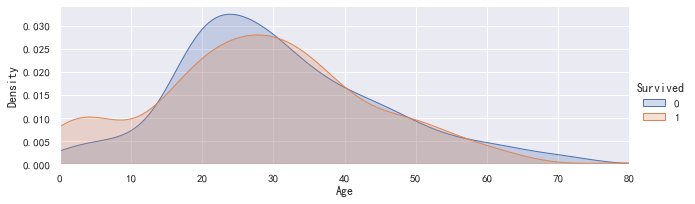

In [59]:
ageFacet = sns.FacetGrid(train_data,hue='Survived',aspect=3)
ageFacet.map(sns.kdeplot,'Age',shade=True)
ageFacet.set(xlim=(0,train_data['Age'].max()))
ageFacet.add_legend()

性别的统计分析使用条形图就可以轻松完成，从下图来看，女性的生存率远高于男性，后续在统计时需要将女性这一因素纳入重点考虑范围。

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

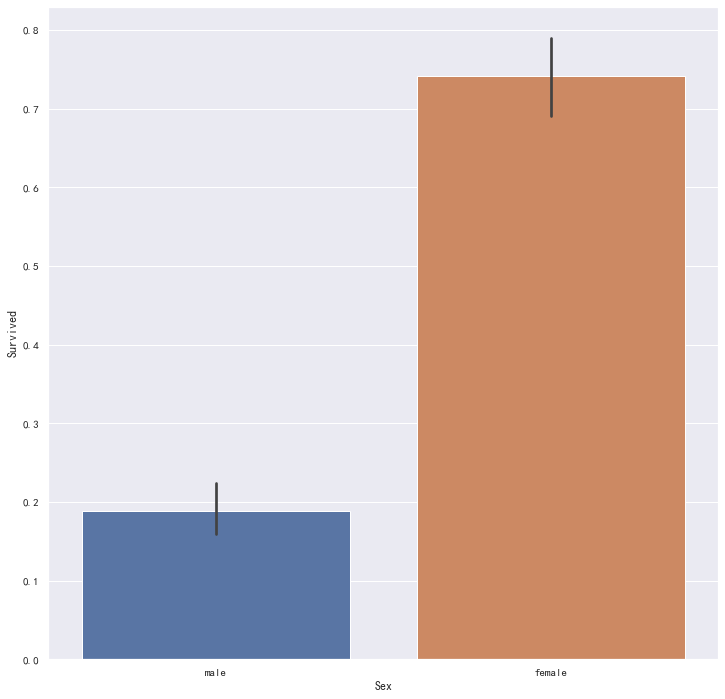

In [60]:
sns.barplot(x='Sex',y='Survived',data=train_data)

## 数据清洗

### 加载数据集
重新加载训练数据集，以防止前面数据分析部分对变量进行了修改

In [61]:
test_data = pd.read_csv("kaggle/input/titanic/test.csv")
train_data = pd.read_csv("kaggle/input/titanic/train.csv")

为方便后续数据的清洗，现将测试集与训练集进行合并

In [62]:
# join the two datasets
titanic = pd.concat([train_data, test_data])

合并后的数据集变为：

In [63]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 缺失值处理
从新合并的数据集来看，在Age, Fare, Cabin, Embarked这四个属性上有缺失值需要进行处理。


In [64]:
titanic.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Embarked和Cabin都是类型数据，并且在数据分析中没有看出与别的属性有明显的区别，首先考虑以下处理方式：
* Embarked属性缺失较少，所以我选择直接使用最多的类来进行缺失值的填补
* 对于Cabin，将缺失值标志位U (Unknown)，并且仅取第一个字母作为有效值

In [65]:
titanic['Embarked'].fillna('S', inplace = True)
titanic['Cabin'].fillna('U', inplace = True)
titanic['Cabin'] = titanic['Cabin'].map(lambda x: x[0])

Fare缺失值虽然是数值属性，但缺失值只有一个并且再数据分析部分已经得出结论：Fare与Pclass高度相关，所以直接使用同一Pclass的票价均值来填补缺失。

In [66]:
titanic['Fare'].fillna(titanic.groupby('Pclass')['Fare'].transform('median'), inplace=True)

经过上述简单处理之后暂时只有Age数据需要填补缺失值

In [67]:
print(titanic.isnull().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64


### 特征提取

在数据分析部分我们提到，Age缺失值的填补依赖于其他属性，所以想要尽量有效地填补缺失的年龄，我们首先需要对尽可能地挖掘其他属性的特征。所以接下来需要做的事情就是分析各个非数字属性，并且将其转化为有效数值属性。

首先需要处理的是Name属性，通过直接观察，我们发现Name中会带有职位或者性别信息，所以通过分割进行处理。

In [68]:
titanic['Title'] = titanic['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
titanic.drop('Name', axis=1, inplace=True)
titanic['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [69]:
print(titanic.isnull().sum())

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title            0
dtype: int64


In [70]:
titanic['Title'] = titanic['Title'].replace(['Rev', 'Dr', 'Col', 'Lady', 'Sir', 'Don', 'Capt', 'the Countess', 'Jonkheer', 'Dona', 'Major'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')
titanic['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

接下来分析SibSp与Parch这一属性，这一属性反映的是家庭成员数量，在决策树模型，连续的数值是不必要甚至影响正确判断的，所以需要根据家庭成员数量的大小将乘客分类为两种类型：独自和非独自。

In [71]:
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
# titanic['Family'] = pd.cut(titanic['FamilySize'], [0, 1, 4, 7, 11], labels=['Single', 'Small', 'Medium', 'Large'])
# titanic['Family'].value_counts()

titanic['Alone'] = titanic['FamilySize'].map(lambda x: 1 if x == 1 else 0)
titanic.drop(['SibSp', 'Parch', 'FamilySize'], axis=1, inplace=True)
titanic['Alone'].value_counts()

1    790
0    519
Name: Alone, dtype: int64

暂时无法从Ticket中发掘出有用的信息，所以在此实验中我将Ticket忽略

In [72]:
titanic.drop(['Ticket'], axis=1, inplace=True)

经过上述一系列处理，最终得到了以下特征：

In [73]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0.0,3,male,22.0,7.2500,U,S,Mr,0
1,2,1.0,1,female,38.0,71.2833,C,C,Mrs,0
2,3,1.0,3,female,26.0,7.9250,U,S,Miss,1
3,4,1.0,1,female,35.0,53.1000,C,S,Mrs,0
4,5,0.0,3,male,35.0,8.0500,U,S,Mr,1


接下来便是对Cabin与Embarked的分析处理，由于需要使用随机森林对Age进行预测，在此过程中此类型属性最好被转化为数值属性。

In [74]:
titanic['Cabin'].value_counts()
titanic['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

In [75]:
# map categorical features to numerical values
titanic['Cabin'] = titanic['Cabin'].map({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7, 'U' : 8})
titanic['Sex'] = titanic['Sex'].map({'male' : 0, 'female' : 1})
titanic['Embarked'] = titanic['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2})
titanic['Title'] = titanic['Title'].map({'Mr' : 0, 'Miss' : 1, 'Mrs' : 2, 'Master' : 3, 'Rare' : 4})

一切都转化完毕后可以查看现在的数据集如下：

In [76]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   int64  
 4   Age          1046 non-null   float64
 5   Fare         1309 non-null   float64
 6   Cabin        1309 non-null   int64  
 7   Embarked     1309 non-null   int64  
 8   Title        1309 non-null   int64  
 9   Alone        1309 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 112.5 KB


In [77]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0.0,3,0,22.0,7.2500,8,0,0,0
1,2,1.0,1,1,38.0,71.2833,2,1,2,0
2,3,1.0,3,1,26.0,7.9250,8,0,1,1
3,4,1.0,1,1,35.0,53.1000,2,0,2,0
4,5,0.0,3,0,35.0,8.0500,8,0,0,1


In [78]:
print(titanic.isnull().sum())

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age            263
Fare             0
Cabin            0
Embarked         0
Title            0
Alone            0
dtype: int64


至此，除Age之外的属性都已处理完毕，接下来需要对Age进行处理，其中我们需要分析Age的分布情况，并且将其转化为数值属性。在此之前需要大致的决定哪些属性与Age最密切，使用heatmap来直观的查看相关系数。

(10.5, -0.5)

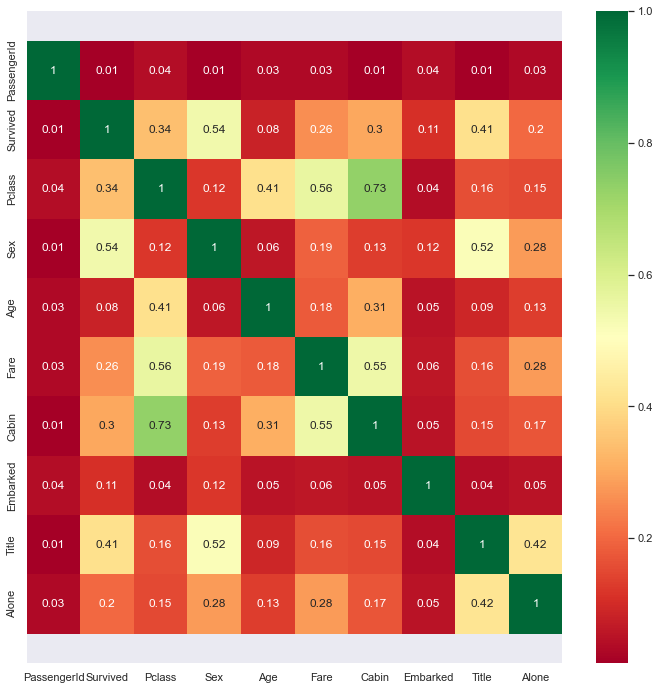

In [79]:
import seaborn as sns
correlation_matrix = np.absolute(titanic.corr().round(2))
sns.set(rc={'figure.figsize':(12, 12)})
ax = sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [80]:
variables = ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Alone']
titanicAge = titanic[variables]

ageTrain = titanicAge[titanicAge['Age'].notnull()]
agePredict = titanicAge[titanicAge['Age'].isnull()]

Train_X = ageTrain.drop(['Age'],axis=1)
Train_y = ageTrain['Age']

Predict_X = agePredict.drop(['Age'],axis=1)
#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=None, n_estimators=500, n_jobs=-1)
model.fit(Train_X, Train_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [81]:
# 预测并填充
Predict_y = model.predict(Predict_X)
titanic.loc[titanic['Age'].isnull(), ['Age']] = Predict_y
# 预测模型得分
model.score(Train_X, Train_y)

0.7408137654982324

经过上述处理，数据集中的缺失值已经被全部填补完毕

In [82]:
titanic.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
Fare             0
Cabin            0
Embarked         0
Title            0
Alone            0
dtype: int64

由于决策树算法限制，为达到最佳效果，我们还需要把连续属性进行归类。

In [83]:
titanic.loc[titanic['Fare'] <= 7.91, 'Fare'] = 0
titanic.loc[(titanic['Fare'] > 7.91) & (titanic['Fare'] <= 14.454), 'Fare'] = 1
titanic.loc[(titanic['Fare'] > 14.454) & (titanic['Fare'] <= 31), 'Fare'] = 2
titanic.loc[titanic['Fare'] > 31, 'Fare'] = 3

titanic.loc[titanic['Age'] <= 16, 'Age'] = 0
titanic.loc[(titanic['Age'] > 16) & (titanic['Age'] <= 32), 'Age'] = 1
titanic.loc[(titanic['Age'] > 32) & (titanic['Age'] <= 48), 'Age'] = 2
titanic.loc[(titanic['Age'] > 48) & (titanic['Age'] <= 64), 'Age'] = 3
titanic.loc[titanic['Age'] > 64, 'Age'] = 4

titanic['Age'] = titanic['Age'].astype(int)
titanic['Fare'] = titanic['Fare'].astype(int)

In [84]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0.0,3,0,1,0,8,0,0,0
1,2,1.0,1,1,2,3,2,1,2,0
2,3,1.0,3,1,1,1,8,0,1,1
3,4,1.0,1,1,2,3,2,0,2,0
4,5,0.0,3,0,2,1,8,0,0,1


## 模型预测
数据清洗和特征提取完毕之后就可以使用模型进行学习和预测了，首先恢复测试集与训练集

In [85]:
traindata = titanic[titanic['Survived'].notnull()]
testdata = titanic[titanic['Survived'].isnull()]

In [86]:
# 将Survived类转为int类型
traindata['Survived'] = traindata['Survived'].astype(int)
traindata

C:\Users\chris\AppData\Local\Temp\ipykernel_18476\948573567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata['Survived'] = traindata['Survived'].astype(int)


,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0,3,0,1,0,8,0,0,0
1,2,1,1,1,2,3,2,1,2,0
2,3,1,3,1,1,1,8,0,1,1
3,4,1,1,1,2,3,2,0,2,0
4,5,0,3,0,2,1,8,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,1,1,8,0,4,1
887,888,1,1,1,1,2,1,0,1,1
888,889,0,3,1,0,2,8,0,1,0
889,890,1,1,0,1,2,2,1,0,1


In [87]:
testdata

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,892,NaN,3,0,2,0,8,2,0,1
1,893,NaN,3,1,2,0,8,0,2,0
2,894,NaN,2,0,3,1,8,2,0,1
3,895,NaN,3,0,1,1,8,0,0,1
4,896,NaN,3,1,1,1,8,0,2,0
...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,0,1,1,8,0,0,1
414,1306,NaN,1,1,2,3,2,1,4,1
415,1307,NaN,3,0,2,0,8,0,0,1
416,1308,NaN,3,0,1,1,8,0,0,1


### 随机森林
使用随机森林进行预测，并且使用交叉验证，选择最优的参数。首先使用简单的随机森林执行一次预测得到的得分应该为0.79186-0.79425之间（由随机状态决定），无法满足我们的需求。

![simple](./simple.png)

In [88]:
from sklearn.ensemble import RandomForestClassifier

y = traindata['Survived']
X = traindata.drop(['Survived', 'PassengerId'], axis=1)
X_test = testdata.drop(['Survived', 'PassengerId'], axis=1)

model = RandomForestClassifier(n_estimators=30, max_depth=6, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission1.csv', index=False)
print("Your submission1 was successfully saved!")

Your submission1 was successfully saved!


使用GridSearchCV对随机森林进行参数调优，选择最优的参数。

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

In [93]:
# 选择参数范围
modelRFC = RandomForestClassifier()
n_estimators = list(range(20, 200, 1))# [20-50]
max_depth = list(range(1, 10, 1))

params = {
            "max_depth": max_depth,
            "n_estimators" :n_estimators,
        }

modelRFC_GCCV = GridSearchCV(modelRFC, param_grid = params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
modelRFC_GCCV.fit(X, y)

modelRFCBest = modelRFC_GCCV.best_estimator_

Fitting 10 folds for each of 1620 candidates, totalling 16200 fits


In [96]:
modelRFCBest.fit(X, y)
predictions = modelRFCBest.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission_RFC.csv', index=False)

### GBC

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rate = [1, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 32, 100]
max_depth = list(range(1, 20, 1))

modelGBC = GradientBoostingClassifier()
params = {
            'loss' : ["deviance"],
            'n_estimators' : n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
        }

modelGBC_GCCV = GridSearchCV(modelGBC, param_grid = params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
modelGBC_GCCV.fit(X, y)

modelGBCBest = modelGBC_GCCV.best_estimator_

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits


In [51]:
modelGBCBest.fit(X, y)
predictions = modelGBCBest.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission_GBC.csv', index=False)

### SVMC

In [52]:
from sklearn.svm import SVC

SVMC = SVC(probability=True)

C = [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300]
gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    
params = {
            'kernel': ['rbf'], 
            'gamma': gamma,
            'C': C,
        }

modelSVMC_GCCV = GridSearchCV(SVMC, param_grid = params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
modelSVMC_GCCV.fit(X, y)
modelSVMCBest = modelSVMC_GCCV.best_estimator_

Fitting 10 folds for each of 66 candidates, totalling 660 fits


In [53]:
modelGBCBest.fit(X, y)
predictions = modelGBCBest.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission_SVC.csv', index=False)

### XGBoost


In [54]:
from xgboost import XGBClassifier

XGB = XGBClassifier()

max_depth = [1, 2, 4, 8, 10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 
gamma = np.linspace(0.5, 5, 5, endpoint=True)

params = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'max_depth': max_depth
}


modelXGB_GCCV = GridSearchCV(estimator = XGB, param_grid = params, cv = kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
modelXGB_GCCV.fit(X, y)

modelXGBBest = modelXGB_GCCV.best_estimator_

Fitting 10 folds for each of 3125 candidates, totalling 31250 fits


In [55]:
modelXGBBest.fit(X, y)
predictions = modelXGBBest.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission_XGB.csv', index=False)

### 组合模型(Ensemble)
组合模型就是将上述决策模型组合到一起，以期获得最好的效果。在此次实验中，我选择的组合方式是使用决策树。首先可以将四种模型在交叉验证上的得分展示出来：

In [56]:
print('RFC Score: ', modelRFC_GCCV.best_score_)
print('GBC Score: ',modelGBC_GCCV.best_score_)
print('SVMC Score: ', modelSVMC_GCCV.best_score_)
print('XGB Score: ', modelXGB_GCCV.best_score_)

RFC Score:  0.8238202247191012
GBC Score:  0.8282896379525593
SVMC Score:  0.827116104868914
XGB Score:  0.8339076154806493


使用VotingClassifier组合模型

In [57]:
from sklearn.ensemble import VotingClassifier

votingTree = VotingClassifier(estimators=[('GBC', modelGBCBest), ('SVM', modelSVMCBest), ('XGB', modelXGBBest), ("RandomForest", modelRFCBest)], voting='soft', n_jobs=-1)
votingTree = votingTree.fit(X, y)

使用组合模型进行预测，并且将预测结果写入文件

In [58]:
predictions = votingTree.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission2.csv', index=False)